In [1]:
import comet_ml
from comet_ml.integration.pytorch import log_model

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
class Model(nn.Module):

    def __init__(self,in_features=4,h1=8,h2=9,out_features=3):
        # decide the number of layers
        # create an attribute for each layer and decide the type of layer
        # Input Layer (4 features) --> (n neurons) h1 --> (n neurons)  h2 --> output ( 3 classes)

        super().__init__()  # Instantiate the super class
        self.fc1 = nn.Linear(in_features,h1) # 4 features in and 8 features for the firs hidden layer out
        self.fc2 = nn.Linear(h1,h2) # 8 features from the first hidden layer in and 9 features for the next hidden layer out.
        self.out = nn.Linear(h2,out_features) # 9 features from the 2nd hidden layer in and 3 class based selection out


       
    def forward(self,x):
        x = F.relu(self.fc1(x)) # Passing the input through the weights and bias of this layer and then passing it through the activation function
        x = F.relu(self.fc2(x)) # Passing the output from the input layer to the function and then the activation function
        x = self.out(x)

        return x

loading the dataset

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [4]:
df = pd.read_csv('../datasets/iris_dataset/Iris.csv')
df.head()

labels = ['Iris-setosa','Iris-virginica','Iris-versicolor']

df['Species'] = df['Species'].apply(lambda x: labels.index(x))


In [5]:
# performing a train test split
X = df.drop('Species',axis=1).to_numpy()[:,1:]
y = df['Species'].to_numpy()

print(X[0])
print(y[0])

[5.1 3.5 1.4 0.2]
0


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_test,X_val,y_test,y_val = train_test_split(X_test,y_test,test_size=0.5,random_state=42)

In [7]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
X_val = torch.FloatTensor(X_val)


In [8]:
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)
y_val = torch.LongTensor(y_val)

In [9]:
comet_ml.init()

experiment = comet_ml.Experiment(project_name='juan-ai',
                                 auto_histogram_weight_logging=True,
                                 auto_histogram_gradient_logging=True,
                                 auto_histogram_activation_logging=True,)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/wereign/juan-ai/3dfafc069a134a24bc61e86208beb2da



In [10]:
parameters = {
    "epochs":100,
    "optimizer":"Adam",
    "learning_rate":0.01,
    "loss":"crossentropy",
    "validation_split":0.1,
    "test_split":0.1
}

experiment.log_parameters(parameters)

In [11]:
model = Model()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)

log_model(experiment,model,model_name='pytorch_iris_linear')

c:\Users\viren\miniconda3\envs\autogluon_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
import time

start_time = time.time()

epochs = 100
train_losses = []
train_accuracy = []

val_losses = []
val_accuracy = []

for i in range(epochs):

    trn_corr = 0
    tst_corr = 0

    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)

    predicted = torch.max(y_pred.data, 1)[1]
    accuracy = ((predicted == y_train).sum() / len(predicted))
    train_accuracy.append(accuracy.item())
    train_losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        y_val_pred = model(X_val)
        val_predicted = torch.max(y_val_pred.data, 1)[1]

        accuracy = ((val_predicted == y_val).sum() / len(val_predicted))

        loss = criterion(y_val_pred, y_val)
        val_losses.append(loss.item())
        val_accuracy.append(accuracy.item())

        if i % 10 == 0:
            print()
            print(f"Epoch: {i}")
            print(f"Training Set:\n Accuracy: {accuracy*100:.2f}% Loss:{loss:.2f}")
            print(f"Validation Set:\n Epoch: {i} Accuracy: {accuracy*100:.2f}% Loss:{loss:.2f}")
            print()


Epoch: 0
Training Set:
 Accuracy: 33.33% Loss:1.19
Validation Set:
 Epoch: 0 Accuracy: 33.33% Loss:1.19


Epoch: 10
Training Set:
 Accuracy: 60.00% Loss:0.97
Validation Set:
 Epoch: 10 Accuracy: 60.00% Loss:0.97


Epoch: 20
Training Set:
 Accuracy: 80.00% Loss:0.64
Validation Set:
 Epoch: 20 Accuracy: 80.00% Loss:0.64


Epoch: 30
Training Set:
 Accuracy: 93.33% Loss:0.35
Validation Set:
 Epoch: 30 Accuracy: 93.33% Loss:0.35


Epoch: 40
Training Set:
 Accuracy: 93.33% Loss:0.19
Validation Set:
 Epoch: 40 Accuracy: 93.33% Loss:0.19


Epoch: 50
Training Set:
 Accuracy: 93.33% Loss:0.11
Validation Set:
 Epoch: 50 Accuracy: 93.33% Loss:0.11


Epoch: 60
Training Set:
 Accuracy: 100.00% Loss:0.08
Validation Set:
 Epoch: 60 Accuracy: 100.00% Loss:0.08


Epoch: 70
Training Set:
 Accuracy: 100.00% Loss:0.06
Validation Set:
 Epoch: 70 Accuracy: 100.00% Loss:0.06


Epoch: 80
Training Set:
 Accuracy: 100.00% Loss:0.05
Validation Set:
 Epoch: 80 Accuracy: 100.00% Loss:0.05


Epoch: 90
Training Set:

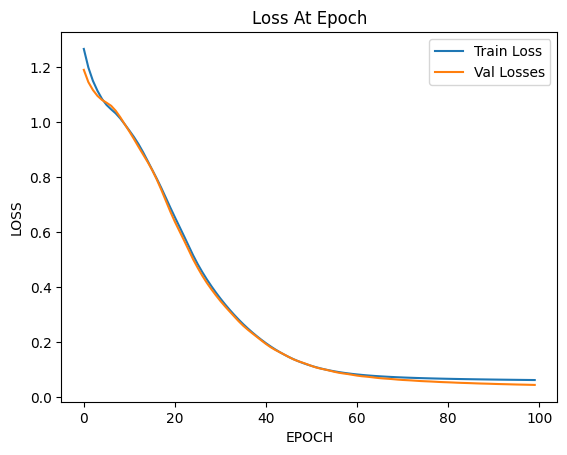

In [13]:
plt.plot(train_losses,label='Train Loss')
plt.plot(val_losses,label='Val Losses')
plt.ylabel("LOSS")
plt.xlabel("EPOCH")
plt.title("Loss At Epoch")
plt.legend()

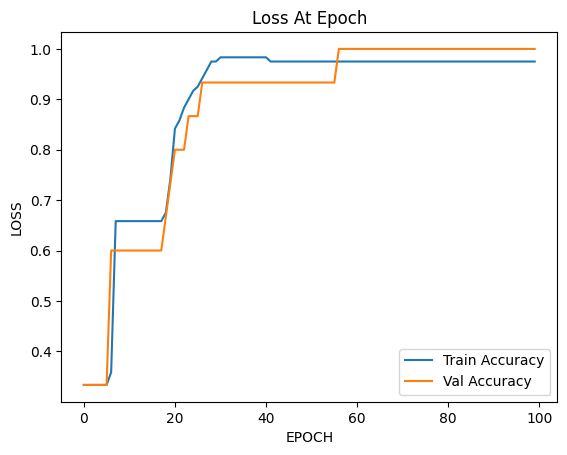

In [14]:
plt.plot(train_accuracy,label='Train Accuracy')
plt.plot(val_accuracy,label='Val Accuracy')
plt.ylabel("LOSS")
plt.xlabel("EPOCH")
plt.title("Loss At Epoch")
plt.legend()

# Test Dataset

In [15]:
y_test_predictions = model(X_test)
val_predicted = torch.max(y_test_predictions.data, 1)[1]

accuracy = ((val_predicted == y_test).sum() / len(val_predicted))

loss = criterion(y_test_predictions, y_test)

In [16]:
loss

tensor(0.0868, grad_fn=<NllLossBackward0>)

In [17]:
accuracy

tensor(1.)

In [18]:
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_test,val_predicted)
experiment.log_confusion_matrix(matrix=confusion_matrix)

{'web': 'https://www.comet.com/api/asset/download?assetId=0866737ace4741c1bbc377a897056882&experimentKey=3dfafc069a134a24bc61e86208beb2da',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=0866737ace4741c1bbc377a897056882&experimentKey=3dfafc069a134a24bc61e86208beb2da',
 'assetId': '0866737ace4741c1bbc377a897056882'}

Text(50.72222222222221, 0.5, 'actual')

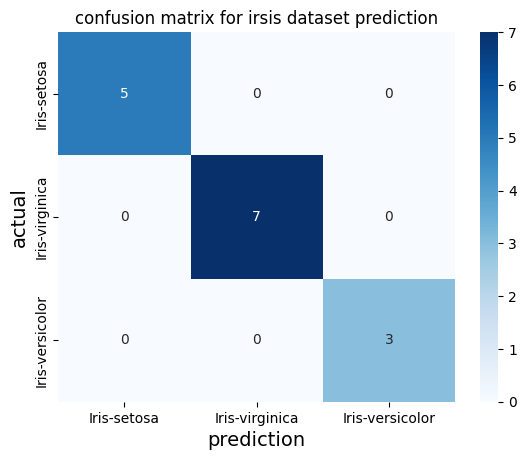

In [19]:
import seaborn as sns

ax = sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)#0 =setosa , 1 = versicolor , 2 = virginica
ax.set_title('confusion matrix for irsis dataset prediction')
ax.set_xlabel('prediction', fontsize=14)
ax.set_ylabel('actual', fontsize=14)

In [20]:
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/wereign/juan-ai/3dfafc069a134a24bc61e86208beb2da
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [10] : (0.06405146420001984, 1.2667053937911987)
COMET INFO:   Parameters:
COMET INFO:     epochs           : 100
COMET INFO:     learning_rate    : 0.01
COMET INFO:     loss             : crossentropy
COMET INFO:     optimizer        : Adam
COMET INFO:     test_split       : 0.1
COMET INFO:     validation_split : 0.1
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     confusion-matrix  

In [23]:
model_scripted = torch.jit.script(model)
torch.jit.save(model_scripted,'../saved_models/iris_model_pytorch.pt')